# Quantify Time to Test

In this notebook, the Key Performance Indicator that we capture is `the time to test` for the test Overall or `the total runtime` for builds as it would help filter and observe builds with longer than expected runtimes.

By measuring this metric, we can observe the trend of build runtimes and check if the execution time of the builds exceed the specified values. If the execution of the test suite takes a long time, we may wish to optimize our test code or track down tests that are taking too long. This metric can also be used to draw a correlation to the tests turning out to be flaky.

In this notebook, we capture:
* Time taken to run builds over time

_Linked issues: [issue1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/117)_

In [1]:
import os
import json
import datetime
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk, read_from_disk
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

For extracting this metric, we will dig into the time series data in the detailed test grids. In this notebook, we use the `Overall` tests as our proxy for builds.

There are inbuilt Graphs within TestGrid for each Test in the job, which capture the time taken for running each test.

As a part of our data download and extraction process we are capturing time taken not for all tests but the test `Overall` which can be used as a proxy for a Build since time durations are not consistently captured for all tests. Thus in this notebook, we capture time elapsed for each Build.

In [2]:
## Specify variables

METRIC_NAME = "time_to_test"

# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_183.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Metric Calculation
We find runtimes for each Test Overall or Build

In [4]:
# We pass status code as None since we are not filtering by Status here
testgrid_list = testgrid_labelwise_encoding(testgrid_data, None)

In [5]:
len(testgrid_list)

29292485

In [6]:
testgrid_list[0]

(datetime.datetime(2021, 4, 14, 16, 12, 4),
 '"redhat-assisted-installer"',
 'periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted',
 'Overall',
 105.58333333333333)

In [7]:
# Convert to dataframe
testgrid_df = pd.DataFrame(
    testgrid_list, columns=["timestamp", "tab", "job", "test", "test_duration"]
)
testgrid_df.head()

,timestamp,tab,job,test,test_duration
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333


In [8]:
# time durations are captured currently for the Test Overalls, hence we filter
testgrid_df = testgrid_df[testgrid_df["test"] == "Overall"]

In [9]:
testgrid_df = testgrid_df.loc[testgrid_df.test_duration.notnull()]

In [10]:
testgrid_df.head()

,timestamp,tab,job,test,test_duration
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333


In [11]:
len(testgrid_df)

40061

## Metric Calculation
We want to calcluate the average time duration for the job/build

In [12]:
average_time = (
    testgrid_df.groupby(["tab", "job", "test"])["test_duration"].mean().reset_index()
)

In [13]:
average_time.head()

,tab,job,test,test_duration
0,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,98.153333
1,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.126087
2,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,67.072464
3,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,84.342500
4,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,86.331944


## Visualization
Plot of time elapsed for Builds over time.

In [14]:
df = (
    testgrid_df.groupby(["tab", "job", "test"])
    .apply(lambda x: [list(x["test_duration"]), list(x["timestamp"])])
    .apply(pd.Series)
    .reset_index()
)
df.columns = ["tab", "job", "test", "test_duration", "timestamp"]

In [15]:
df.head()

,tab,job,test,test_duration,timestamp
0,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,"[105.58333333333333, 87.21666666666667, 99.1, ...","[2021-04-14 16:12:04, 2021-04-14 15:05:09, 202..."
1,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,"[86.66666666666667, 119.03333333333333, 81.316...","[2021-04-13 14:48:03, 2021-04-12 00:00:39, 202..."
2,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,"[67.91666666666667, 70.0, 64.68333333333334, 6...","[2021-04-13 14:48:07, 2021-04-12 00:00:39, 202..."
3,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,"[83.21666666666667, 82.76666666666667, 94.5166...","[2021-04-13 17:26:21, 2021-04-13 11:18:33, 202..."
4,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,"[99.33333333333333, 90.23333333333333, 93.2333...","[2021-04-13 17:26:23, 2021-04-13 11:18:36, 202..."


In [16]:
def plot_build_graph(dashboard, job, dataframe):

    test_duration = dataframe.loc[
        (df["tab"] == dashboard) & (dataframe["job"] == job), "test_duration"
    ].iloc[0]
    timestamp = dataframe.loc[
        (df["tab"] == dashboard) & (dataframe["job"] == job), "timestamp"
    ].iloc[0]

    time_taken_df = pd.DataFrame(
        {"timestamp": timestamp, "time_duration": test_duration}
    )

    sns.set(rc={"figure.figsize": (17, 10)})
    sns.lineplot(x="timestamp", y="time_duration", data=time_taken_df)
    plt.xlabel("Timestamps")
    plt.ylabel("Time Taken to Run Job or Build (mins)")
    plt.title("Job/Build Duration over time ")
    plt.show()

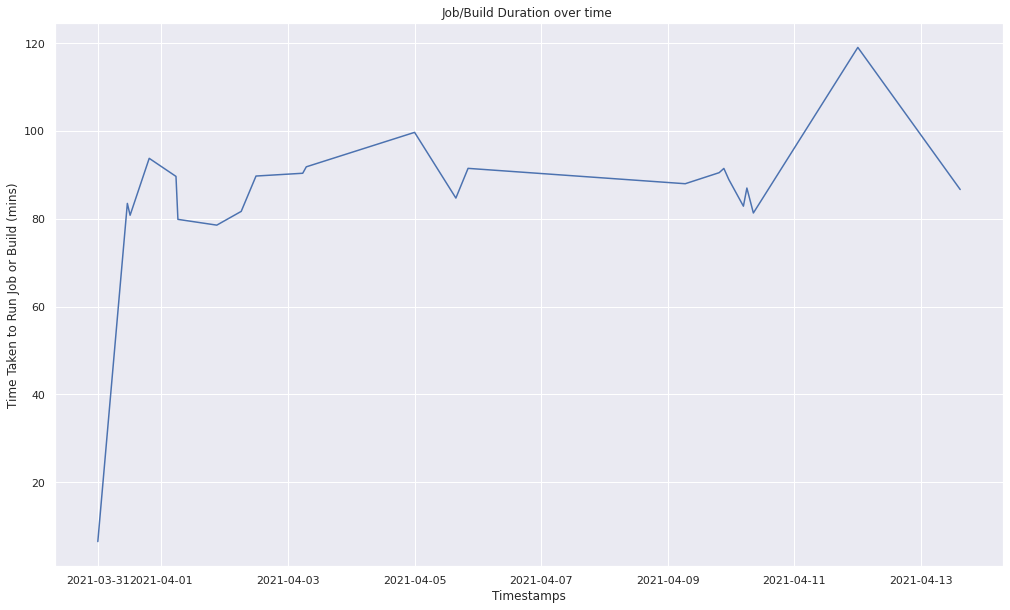

In [17]:
plot_build_graph(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    df,
)

In the above graph, we see how the time taken to run a build changes over time and we notice when there are spikes or when irregular builds occur.

## Save to Ceph or local

In [18]:
timestamp = datetime.datetime.now()

if AUTOMATION:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(
        average_time,
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    save_to_disk(
        average_time,
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

In [19]:
## Sanity check to see if the dataset is the same
if AUTOMATION:
    sanity_check = cc.read_from_ceph(
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    sanity_check = read_from_disk(
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

sanity_check

,tab,job,test,test_duration
0,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,98.153333
1,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.126087
2,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,67.072464
3,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,84.342500
4,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,86.331944
...,...,...,...,...
560,"""redhat-osd""",osde2e-stage-moa-e2e-default,Overall,106.916667
561,"""redhat-osd""",osde2e-stage-moa-e2e-next-y,Overall,0.100000
562,"""redhat-osd""",osde2e-stage-moa-e2e-next-z,Overall,0.100000
563,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,116.664444


### Conclusion

In this Notebook, we use the "Overall" as a proxy for a build. Testgrid refers an aggregate of multiple tests performed at a certain timestamp within a Job as a Build and each build has a unique Build ID. In this notebook, we went ahead and used the captured time duration for Test Overalls and averged them out for each Job. We also plotted the time taken for builds to complete over time for each Job.